#CONTENT BASED IMAGE RETRIEVAL<br/>
##Digital Signal and Image Management Project 2021-2022<br/>

Matteo Cesaro - 867350 - m.cesaro1@campus.unimib.it<br/>
Francesco Martinelli - 873685 - f.martinelli21@campus.unimib.it<br/>
Cristiano Ruttico - 809360 - c.ruttico@campus.unimib.it<br/>

La prima cosa da fare è selezionare la runtime di tipo Gpu, perciò:

Selezionare Runtime --> Cambia tipo di hardware --> Acceleratore Hardware: 'GPU'

#MOUNTING DRIVE

Viene collegato il notebook al drive contente il dataset.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


#IMPORTING LIBRERIE



Si importano tutte le librerie necessarie al processamento dei dati e alla costruzione del modello. 

In [2]:
# Keras modules
from tensorflow import keras
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Data loading
from shutil import copyfile
import tarfile
from tensorflow.keras.preprocessing import image

#KDtree
import sklearn
from sklearn.neighbors import KDTree
import joblib

# Misc
from time import time
from matplotlib import pyplot as plt
import numpy as np
import os
import io
import zipfile
import pickle

#Model Specialization
from tensorflow.keras.models import Model

#LOADING MODELLO 

Viene importata e mostrata l'architettura utilizzata per implementare la feature extraction. Si tratta dell'architettura MobileNetV2 con i pesi relativi alla ImageNet Challenge.


Settiamo include_top = False perchè non ci interessa l'ultimo fully connected connesso alle 100 classi di ImageNet ma per il nostro task è importante ottenere le feature selezionate nel penultimo layer della rete.

In [3]:
base_model = keras.applications.MobileNetV2(input_shape=(224,224,3),
                                          weights='imagenet',
                                          include_top=False,
                                          pooling='avg')

9420800/9406464 [==============================] - 0s 0us/step


#GESTIONE FILE

Si copia il dataset compresso sulla macchina utilizzata in Cloud e lo si estrae.

In [4]:
#Durata comando trasferimento 37s
copyfile('/content/gdrive/MyDrive/UNIMIB/DigitalSignalAndImageManagement/DigitalSignal/Retrieval/thumbnails_features_deduped_publish.zip', 'thumbnails_features_deduped_publish.zip')

'thumbnails_features_deduped_publish.zip'

In [5]:
t0 = time()
archivio = zipfile.ZipFile('thumbnails_features_deduped_publish.zip')
archivio.extractall()
archivio.close()
print("File transfer completed in %0.3f seconds" % (time() - t0))

File transfer completed in 59.320 seconds


#ESEMPIO PROCESSAMENTO UNA IMMAGINE DATASET 

La target size dell'input è di (224,224) poichè ai fini della successiva implementazione del transfer learning è indicato che le immagini rispettino l'input size dell'architettura originale e anche il preprocessing dell'architettura.

In [ ]:
img = kimage.load_img('/content/thumbnails_features_deduped_publish/50 cent/0.jpg', target_size=(224,224))

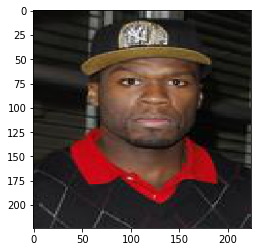

In [ ]:
plt.imshow(img)

In [ ]:
type(img)

PIL.Image.Image

Libreria pillow abbastanza utilizzata per processamento di immagini, per comodità però convertiamo il tipo in numpy array perchè più facile da manipolare

In [ ]:
x = kimage.img_to_array(img)

In [ ]:
type(x)

numpy.ndarray

In [ ]:
print(x.min(),x.max())
print(x.shape)

0.0 255.0
(224, 224, 3)


L' Immagine presenta valori da 0 a 255, quindi c'è sia un punto nell'immagineesattamente nero (0) e sia un punto che corrisponde esattamente bianco(255). Il problema è però che tutto è codificato in floating point. 

Per quanto riguarda la shape come ci si aspetta abbiamo tre dimensioni con il colore dei canali.

Prepariamo perciò l'immagine per essere processata dalla rete mobilenet_v2 e per motivi strutturali aggiungiamo una dimensione fittizia.

In [ ]:
x = keras.applications.mobilenet_v2.preprocess_input(x)
x = np.expand_dims(x, axis=0)

In [ ]:
print(x.min(),x.max())
print(x.shape)

-1.0 1.0
(1, 224, 224, 3)


net.predict viene usata in questo caso perchè abbiamo settato in precedenza per il loading del modello 'incliude_top' = False e perciò l'output della rete non è la classe o la distribuzione di probabilità sulle mille classi ma è la penultima attivazione che utilizzeremo come feature ovvero come descrittore delle nostre immagini.

Non abbiamo quindi come output le etichette associate alle immagini o la distribuzione di probabilità associata alle diverse classi.

In [ ]:
features = net.predict(x)

In [ ]:
features.shape

(1, 1280)

La shape (1, 1280) è relativa a:

Prima dimensione: corrisponde alla dimensione fittizia definita in precedenza.

Seconda dimensione: vettore lungo 1280 elementi. 

#PREPROCESSING IMMAGINI DATASET

Viene attribuita ad una variabile la lista degli oggetti presenti nella cartella 'thumbnails_features_deduped_publish' del dataset in ordine alfabetico. Gli oggetti in questione sono le cartelle che contengono le immagini relative ad una particolare specie, il nome della specie in questione è il nome della cartella stessa.

In [ ]:
it = os.listdir("/content/thumbnails_features_deduped_publish")
it.sort()
root_dir = "/content/thumbnails_features_deduped_publish/"

In [ ]:
it[0:10]

['50 cent',
 'aamir khan',
 'aaron carter',
 'aaron eckhart',
 'abhishek bachchan',
 'abigail breslin',
 'abraham lincoln',
 'adam ant',
 'adam brody',
 'adam sandler']

Numero di classi presenti all'interno del dataset

In [ ]:
len(it)

1580

Nel ciclo seguente vengono importate e processate le immagini del dataset. Il ciclo va ad esplorare all'interno della cartella 'thumbnails_features_deduped_publish' e per ciascuna cartella (ovvero per ciascuna classe==ciascuna persona presa in considerazione dal dataset) importa le immagini e le preprocessa.

La target size dell'input è di (224,224) poichè ai fini della successiva implementazione del transfer learning è indicato che le immagini rispettino l'input size dell'architettura originale e anche il preprocessing dell'architettura.

Al contempo per ogni immagine importata assegna il percorso dell'immagine stessa importante per poi trovare l'immagine più simile all'immagine di query selezionata.

Scegliamo con il comando f.endswith('.jpg') solo i file che contengono il formato JPG per evitare altri file con formati diversi presenti all'interno delle cartelle.

Vengono inoltre selezionate le features per ogni immagine per permettere all'algoritmo di KDTree di trovare le immagini con le features più simili all' immagine di query.

Settiamo la variabile maximages per fare alcune prove sul corretto preprocessamento delle immagini.

Il flattening finale è fondamentale per ottenere le features in questione.

In [ ]:
#Defining a compact preprocessing function
t0 = time()
#maximages = 10
categories = it

paths = []
feature = []


i = 0

for ctg in categories:
    path = root_dir + ctg
    for fi,f in enumerate(sorted(os.listdir(path))):
        if f.endswith('.jpg'):# and fi<maximages:
            # Save file path
            path_img = path+"/"+f
            paths.append(path_img)
            
            
            # Load file and extract features
            img = kimage.load_img(path_img, target_size=(224,224))
            x = kimage.img_to_array(img)
            x = keras.applications.mobilenet_v2.preprocess_input(x)
            x = np.expand_dims(x, axis=0)
            f = base_model.predict(x)
            f = f.flatten()
            feature.append(f)
            

print("Image preprocessing completed in %0.3f seconds" % (time() - t0))

Image preprocessing completed in 1002.404 seconds


Esempi di **Tempistiche**:

Totale foto: 202941

*   ``maximages = 2`` --> immagini = 3160 (**1.5%** del totale), tempo circa= **4 minuti**

*   ``maximages = 6`` and ``layer relu 2048`` --> immagini = 9476 (**4.7%** del totale), tempo = **circa 11 minuti**

*   ``maximages = 8``, ``layer relu 2048`` and ``layer relu 1024`` --> immagini = 12640 (**6.2%** del totale), tempo = **circa 13 minuti**

*   ``maximages = 10`` --> immagini = 15792 (**7.8%** del totale), tempo = **circa 16 minuti**

*   ``maximages = 10`` and ``layer relu 2048`` --> immagini = 15792 (**7.8%** del totale), tempo = **circa 18 minuti**

*   ``maximages = 10``, ``layer relu 2048`` and ``layer relu 1024`` --> immagini = 15792 (**7.8%** del totale), tempo = **circa 18 minuti**

*   ``maximages = NULL`` --> immagini = 202941 (**100%** del totale), tempo = **circa 3 ore e 30 minuti**




Trasformo infine la lista delle feature in array per motivi strutturali.

In [ ]:
feature = np.array(feature)

In [ ]:
len(paths)

15792

In [ ]:
len(feature)

9476

In [ ]:
paths[0]

'/content/thumbnails_features_deduped_publish/50 cent/0.jpg'

In [ ]:
feature[0]

array([0.52029115, 0.09095301, 0.        , ..., 0.        , 0.53056204,
       0.11106524], dtype=float32)

In [ ]:
feature.shape

(3160, 100352)

A questo punto dopo aver preprocessato tutte le immagini in questione scegliamo di preprocessare una nuova immagine esterna al dataset per ottenere il descrittore delle features dell'immagine di query e procedere con l'algoritmo di KDTree per trovare l'elemento/gli elementi più simile/i.

In [ ]:
paths[0]

'/content/thumbnails_features_deduped_publish/50 cent/0.jpg'

#CARICAMENTO E PREPROCESSING IMMAGINE QUERY DI PROVA

L'algoritmo KDTree necessita per la query la dimensione fittizia perciò si evita di utilizzare la funzione flatten sulle features della query.

In [ ]:
path_query_image = '/content/gdrive/MyDrive/UNIMIB/DigitalSignalAndImageManagement/DigitalSignal/Pics_beta/fm_pic/75_fm_.jpg'

Operazione di preprocessing vista in precedenza. 

In [ ]:
query = kimage.load_img(path_query_image, target_size=(224,224))
x = kimage.img_to_array(query)
x = keras.applications.mobilenet_v2.preprocess_input(x)
x = np.expand_dims(x, axis=0)
x = base_model.predict(x)
x = x.flatten()
x = np.expand_dims(x, axis=0)

In [ ]:
x.shape

(1, 50176)

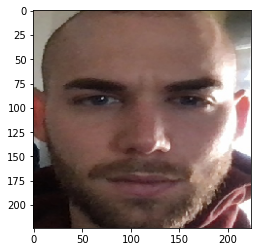

In [ ]:
plt.imshow(query)

#KDTREE RETRIEVAL

Per effettuare la ricerca della foto più simile all'interno del dataset si utilizza un algoritmo chiamato 'KDTREE'.

In [ ]:
tree = KDTree(feature)

La similarità è definita in termini di feature neurali, descriviamo perciò i volti del nostro dataset sia quelli di query(i nostri volti) in termini di feature neurali e di conseguenza andiamo a cercare quali sono i 10 volti più simili a quello scelto come query. Perciò andiamo a vedere quali a vedere le feature neurali che sono più vicine in uno spazio n-dimensionale. tramite l'algoritmo 'KDTREE'.

In [ ]:
dist, ind = tree.query(x, k=1)

'Ind' è un valore tra 0 e 3159 che ci dice quale è l'indice nel nostro dataset delle feature che erano più simili a quelle che abbiamo dato in input, in questo caso è X.

'Dist' è effettivamente la distanza nello spazio 1280-dimensionale tra l'immagine di query e l'immagine che il modello di retrieval ha ritenuto essere più simile.

In [ ]:
ind

array([[12956]])

In [ ]:
ind.shape

(1, 1)

Ind e Dist hanno dei valori con due parentesi quadre, questo significa che entrambe contengono due valore: il primo valore corrisponde al numero di immagini_query assegnate, in questo caso solo 1. Il secondo valore corrisponde al numero k assegnato in questo caso uguale a 1, poichè abbiamo chiesto di trovare il più simile.

Si possono perciò specificare più input e richiedere più output.

In [ ]:
dist

array([[73.64972052]])

Carico l'immagine che l'algoritmo di kdtree ha scelto come più simile in termini di features neurali all'immagine scelta.

In [ ]:
answer_image = kimage.load_img(paths[ind[0,0]])

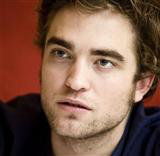

In [ ]:
answer_image

#SAVING KDTREE MODEL AND LIST OF PATHS

Con lo scopo di non dover trainare nuovamente il modello viene salvato in un'apposita directory.

In [ ]:
#per risparmiare RAM
#feature = 0

In [ ]:
joblib.dump(tree,'/content/gdrive/MyDrive/UNIMIB/DigitalSignalAndImageManagement/DigitalSignal/Retrieval/fine_tuning_faces_kdtree.joblib')

['/content/gdrive/MyDrive/UNIMIB/DigitalSignalAndImageManagement/DigitalSignal/Retrieval/fine_tuning_faces_kdtree.joblib']

Il modello trainato viene perciò richiamato tramite la funzione load e può essere così riutilizzato.

Controlliamo inoltre la versione di sklearn poichè non c'è possibilità di retrocompatibilità, ovvero le nuove versioni non sono compatibili con quelle più vecchie e viceversa.

In [ ]:
sklearn.__version__

'1.0.2'

Per poter ritrovare successivamente il paths senza dover nuovamente processare le immagini o trainare il modello salvo in un file a parte tutti i percorsi relativi alle immagini.

In [ ]:
with open("/content/gdrive/MyDrive/UNIMIB/DigitalSignalAndImageManagement/DigitalSignal/Retrieval/fine_tuning_faces_paths", "wb") as fp: 
  pickle.dump(paths, fp)

# LOADING KTREE MODEL AND LIST OF PATHS

In 11 secondi circa si carica il modello di kdtree che ora non deve essere più trainato per essere riutilizzato.

In [6]:
tree = joblib.load('/content/gdrive/MyDrive/UNIMIB/DigitalSignalAndImageManagement/DigitalSignal/Retrieval/faces_kdtree.joblib')

Carico inoltre i paths precedentemente salvati per poter ritrovare l'immagine che l'algoritmo kdtree ha scelto come più simile in termini di feature neurali.

In [7]:
with open("/content/gdrive/MyDrive/UNIMIB/DigitalSignalAndImageManagement/DigitalSignal/Retrieval/paths", "rb") as fp:
  paths = pickle.load(fp)

#TEST IMMAGINE QUERY DEFINITIVO

Carico l'immagine di query definitiva.

In [11]:
plt.rcParams['figure.figsize'] = [20, 9] 

In [22]:
path_query_image = '/content/jacopo3.png'

In [23]:
query_image = kimage.load_img(path_query_image, target_size=(224,224))
x = kimage.img_to_array(query_image)
x = keras.applications.mobilenet_v2.preprocess_input(x)
x = np.expand_dims(x, axis=0)
query_features = base_model.predict(x)

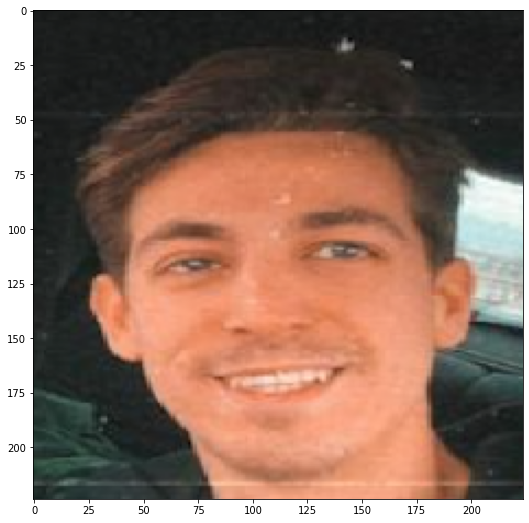

In [24]:
plt.imshow(query_image)

In [25]:
dist, ind = tree.query(query_features, k=10)

In [ ]:
ind

array([[147285,  96972,  42152,   3794,  11294,   7502, 182733,  45169,
        191451,  26634]])

I valori sono già ordinati in maniera decrescente.

In [ ]:
dist

array([[19.78106894, 19.86025619, 20.02937412, 20.07080133, 20.20993633,
        20.2603705 , 20.28423378, 20.40247013, 20.45010116, 20.45677487]])

In [26]:
answer_image_most_similar = kimage.load_img(paths[ind[0,0]])

Mostriamo l'immagine più simile a quella di query.

Text(0.5, 1.0, 'image_most_similar')

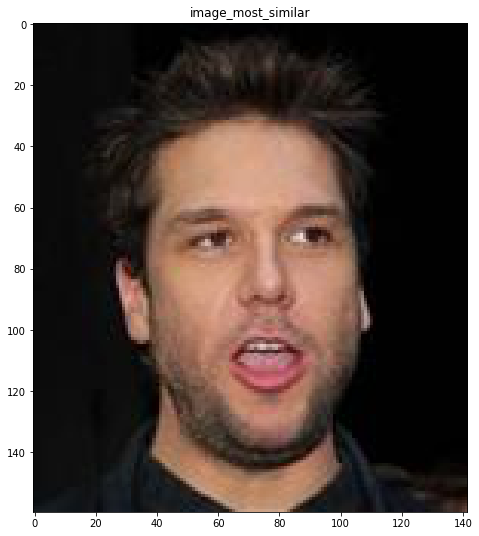

In [27]:
plt.imshow(answer_image_most_similar); plt.title('image_most_similar')

Mostriamo le immagini più simile scelte dall'algoritmo tre immagini alla volta ordinate in maniera decrescente(dalla più simile alla meno simile)

Text(0.5, 1.0, 'fourth_ms')

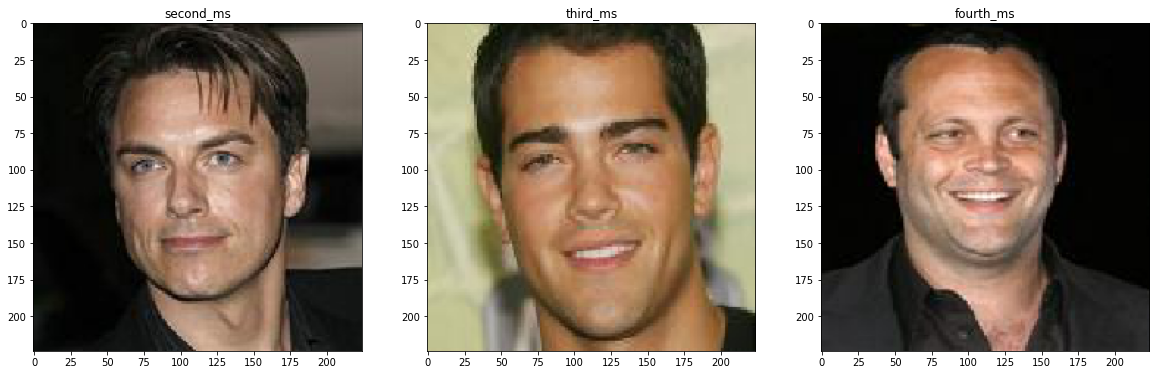

In [28]:
size = (224,224)
plt.subplot(1,3,1);plt.imshow(kimage.load_img(paths[ind[0,1]], target_size=size)); plt.title('second_ms')
plt.subplot(1,3,2);plt.imshow(kimage.load_img(paths[ind[0,2]], target_size=size)); plt.title('third_ms')
plt.subplot(1,3,3);plt.imshow(kimage.load_img(paths[ind[0,3]], target_size=size)); plt.title('fourth_ms')

Text(0.5, 1.0, 'seventh_ms')

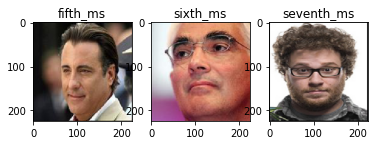

In [ ]:
plt.subplot(1,3,1);plt.imshow(kimage.load_img(paths[ind[0,4]], target_size=size)); plt.title('fifth_ms')
plt.subplot(1,3,2);plt.imshow(kimage.load_img(paths[ind[0,5]], target_size=size)); plt.title('sixth_ms')
plt.subplot(1,3,3);plt.imshow(kimage.load_img(paths[ind[0,6]], target_size=size)); plt.title('seventh_ms')

Text(0.5, 1.0, 'decima_ms')

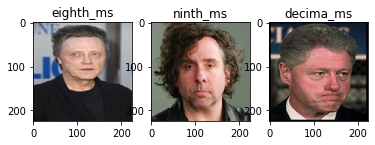

In [ ]:
plt.subplot(1,3,1);plt.imshow(kimage.load_img(paths[ind[0,7]], target_size=size)); plt.title('eighth_ms')
plt.subplot(1,3,2);plt.imshow(kimage.load_img(paths[ind[0,8]], target_size=size)); plt.title('ninth_ms')
plt.subplot(1,3,3);plt.imshow(kimage.load_img(paths[ind[0,9]], target_size=size)); plt.title('decima_ms')